## Orchestrator
In this workbook we'll build a workflow that illustrates _Orchestration_. This is an interesting worflow, where you want the LLM to break down a complex task into sub-tasks and then delegate each subtask to a separate _worker_ and then synthetize the result. This is kind of like parallelization, which we saw in [Parallelization](04-Parallelization.ipynb) notebook, except that the key difference is that you don't know each worker's assignment ahead of time. So you have the LLM reason about the task and then create a bunch of workers based upon its _reasoning_. So the LLM is _gating_ or creating the control workflow (rather than us using the `add_conditional_edges(...)` call.

<div align="center">
<img src="images/05-Orchestrator.png" width="450" heigh="250" alt="Orchestrator Workflow"/>
</div>

In this example we'll mimic deep research. The LLM will reason about the plan for a report and will dynamically generate a bunch of research sections and then goes about researching each section - classic example of an _Orchestrator-Worker_ type workflow.

In [26]:
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from rich.markdown import Markdown
from typing import TypedDict, Annotated, List
import operator
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

In [27]:
load_dotenv(override=True)

console = Console()

In [28]:
# create our LLM - we'll be using Google Gemini flash - let;s make it creative
llm = init_chat_model("google_genai:gemini-2.0-flash", temperature=0.4)

In [29]:
# schema for structured output to use in planning
class Section(BaseModel):
    name: str = (
        Field(
            description="Name for this section of the report",
        ),
    )
    description: str = Field(
        description="""Brief overview of the main topics and concepts to be 
        covered in this section""",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report")


# our planner LLM
planner_llm = llm.with_structured_output(Sections)

c:\Dev\Code\git-projects\learning_langgraph\.venv\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Name for this section of the report'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [30]:
# the graph state
class State(TypedDict):
    topic: str  # the joke topic provided by user
    sections: List[Section]
    # all the workers will write to this field (will add sections)
    completed_sections: Annotated[list, operator.add]
    final_report: str


# worker state - each worker also get its own state
# Why? Because you want to hand off independent inputs to each worker
# and they are self-contained objects. Think of it as a separate bucket in which
# work is being done independently, but writing to the same output
class WorkerState(TypedDict):
    section: Section
    # NOTE: this field has the same name/key as that of the Stategraph.
    # In Langchain, what happens is that when you write to this key, the outer
    # key in StateGraph with the same name also gets updated
    completed_sections: Annotated[list, operator.add]

Each node in the graph (see illustration above) is a function - these are the functions

In [31]:
def orchestrator(state: State):
    """orchestrator that generates plan for report"""
    # NOTE: I am calling planner_llm, which is bound to structured output
    report_sections = planner_llm.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the topic: {state['topic']}"),
        ]
    )
    return {"sections": report_sections.sections}


def generate_sections(state: WorkerState):
    """worker writes a section of the report"""
    response = llm.invoke(
        [
            SystemMessage(content="Write a section of the report"),
            HumanMessage(
                content=f"""Here is the section name: {state['section'].name} and
                    description: {state['section'].description}"""
            ),
        ]
    )
    # will add to the WorkerState.completed_sections Annotated list
    return {"completed_sections": [response.content]}


def synthesizer(state: State):
    """synthesize the final report from all sections"""
    # list of completed sections
    completed_sections = state["completed_sections"]
    # join all sections into a single report
    completed_sections = "\n\n----\n\n".join(completed_sections)
    return {"final_report": completed_sections}


def assign_workers(state: State):
    """dynamically assign # of workers depending on the count of section
    as reasoned by the LLM"""
    # special LangGraph call to generate N sections as determined by the LLM
    return [Send("generate_sections", {"section": s}) for s in state["sections"]]

In [32]:
# build our graph
builder = StateGraph(State)
# add nodes
builder.add_node("orchestrator", orchestrator)
builder.add_node("generate_sections", generate_sections)
builder.add_node("synthesizer", synthesizer)
# add edges
builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", assign_workers, ["generate_sections"])
builder.add_edge("generate_sections", "synthesizer")
builder.add_edge("synthesizer", END)
graph = builder.compile()

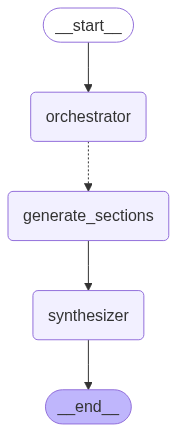

In [33]:
# view the generated graph
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
# invoke the graph
response = graph.invoke(
    {"topic": "Create a report on applications of Generative AI in Investment Banking"}
)

In [35]:
md = Markdown(response["final_report"])
console.print(md)

Introduction                                                    

Generative Artificial Intelligence (AI) is rapidly transforming industries across the globe, and investment banking
is no exception. This report explores the potential impact of generative AI on various aspects of investment       
banking, from enhancing efficiency and accuracy to unlocking new opportunities for innovation and revenue          
generation. Generative AI, encompassing models like Large Language Models (LLMs) and diffusion models, possesses   
the ability to create new content, including text, images, audio, and code, based on patterns learned from vast    
datasets. This capability holds significant promise for automating tasks, augmenting human expertise, and driving  
data-driven decision-making within the complex and demanding landscape of investment banking. This report will     
delve into specific use cases, potential benefits, and challenges associated with the adoption of generative AI in 
this sector.                                                                                                       

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                        Applications in Investment Banking                                         

Generative AI is rapidly transforming various facets of investment banking, offering opportunities to enhance      
efficiency, accuracy, and innovation across the entire value chain. Its ability to generate novel content, analyze 
vast datasets, and personalize interactions is proving invaluable in areas ranging from deal origination to risk   
management.                                                                                                        

1. Deal Origination:                                                                                               

 • Market Trend Identification & Opportunity Generation: Generative AI can analyze news articles, social media     
   trends, and financial reports to identify emerging market trends and potential M&A targets. By synthesizing this
   information, it can generate leads and suggest potential deal structures tailored to specific market conditions 
   and client needs.                                                                                               
 • Pitchbook Generation & Customization: Creating compelling pitchbooks is a time-consuming process. Generative AI 
   can automate the creation of initial drafts, incorporating relevant market data, company profiles, and potential
   synergies. Furthermore, it can personalize these pitchbooks based on the specific client's objectives and risk  
   tolerance, significantly reducing the workload for bankers.                                                     
 • Due Diligence Support: AI can accelerate the initial due diligence process by automatically extracting key      
   information from financial statements, legal documents, and industry reports. This allows bankers to quickly    
   assess the viability of a potential deal and identify potential red flags.                                      

2. Underwriting:                                                                                                   

 • Risk Assessment & Pricing: Generative AI can analyze historical data, market conditions, and company financials 
   to predict the performance of a new security offering. This allows underwriters to more accurately assess risk  
   and determine optimal pricing strategies, minimizing potential losses and maximizing investor interest.         
 • Syndicate Formation & Management: By analyzing investor preferences and past participation in similar deals, AI 
   can assist in identifying potential syndicate members and optimizing the allocation of securities. This leads to
   a more efficient and successful underwriting process.                                           